# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.263593,True,1.876312
1,-0.361264,True,3.708552
2,0.525572,True,8.146120
3,-0.112829,False,-2.109046
4,2.072042,True,10.486636
...,...,...,...
995,-0.787383,True,3.329039
996,-1.578743,False,-4.134269
997,-1.982020,False,-6.911079
998,0.384310,False,2.430874


<AxesSubplot:xlabel='v0'>

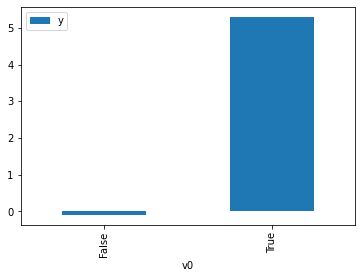

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

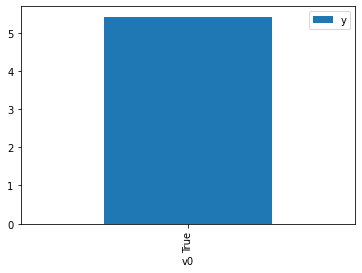

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.607058,False,0.857088,0.184376,5.423700
1,-2.492362,False,-4.688440,0.998596,1.001406
2,0.867356,False,2.399748,0.103087,9.700589
3,1.364923,False,4.186749,0.030579,32.701911
4,-0.604142,False,-3.739017,0.840301,1.190050
...,...,...,...,...,...
995,0.818486,False,3.715023,0.115434,8.662936
996,-1.687469,False,-2.964850,0.988745,1.011383
997,-0.873907,False,-2.234763,0.913843,1.094280
998,-0.477506,False,-2.254143,0.791071,1.264109


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.720907,True,9.250093,0.987647,1.012507
1,0.448961,True,5.892829,0.745763,1.340908
2,-0.335376,True,3.282519,0.276468,3.617058
3,0.441197,True,7.552130,0.741919,1.347857
4,0.235424,True,6.981818,0.627438,1.593784
...,...,...,...,...,...
995,-0.177180,True,3.757236,0.365642,2.734914
996,0.469474,True,7.686622,0.755737,1.323212
997,0.548660,True,6.290465,0.791703,1.263100
998,-0.641024,True,2.975344,0.147253,6.791037


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                          1.257e+04
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        11:27:28   Log-Likelihood:                         -1422.8
No. Observations:                1000   AIC:                                      2850.
Df Residuals:                     998   BIC:                                      2859.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5425      0.035     72.726      0.000       2.474       2.611
x2             4.9501      0.052     95.074      0.000       4.848       5.052
==============================================================================
Omnibus:                        1.866   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.753
Skew:                           0.023   Prob(JB):                        0.416
Kurtosis:                       2.800   Cond. No.                         1.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""